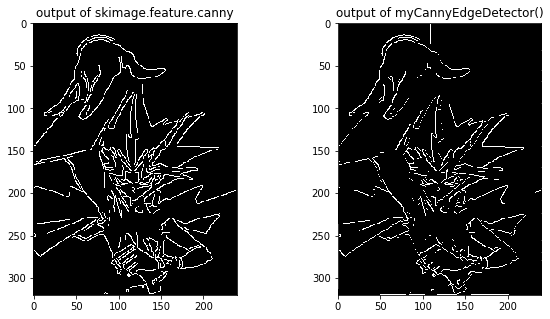

the value of PSNR is :  55.07242161197904


In [1]:
from skimage import io, data,filters,feature
from skimage.color import *
import numpy as np
import matplotlib.pyplot as plt

def myCannyEdgeDetector(image, Low_Threshold, High_Threshold):
    # sobel filter
    def sobel_filter(img, K_size=3):  # K_size : the height of the kernal
        if len(img.shape) == 3:
            width, height, depth = img.shape
        else:
            width, height = img.shape

        # Zero padding
        pad = K_size // 2
        out = np.zeros((width + pad * 2, height + pad * 2), dtype=np.float)
        out[pad: pad + width, pad: pad + height] = img.copy().astype(np.float)
        tmp = out.copy()

        out_v = out.copy()
        out_h = out.copy()

        ## Sobel vertical
        Kv = [[1., 2., 1.], [0., 0., 0.], [-1., -2., -1.]]
        ## Sobel horizontal
        Kh = [[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]

        # filtering
        for iRow in range(width):
            for iCol in range(height):
                out_v[pad + iRow, pad + iCol] = np.sum(Kv * (tmp[iRow: iRow + K_size, iCol: iCol + K_size]))
                out_h[pad + iRow, pad + iCol] = np.sum(Kh * (tmp[iRow: iRow + K_size, iCol: iCol + K_size]))

        # resize the output
        out_v = out_v[pad: pad + width, pad: pad + height]
        fy = out_v#.astype(np.uint8)
        out_h = out_h[pad: pad + width, pad: pad + height]
        fx = out_h#.astype(np.uint8)

        return fy, fx


# get edge strength and edge angle
    def get_edge_angle(fx, fy):
        # get edge strength
        edge = np.sqrt(np.power(fx.astype(np.float32), 2) + np.power(fy.astype(np.float32), 2))

        # make sure the denominator is not 0
        fx = np.maximum(fx, 1e-10)

        # get edge angle
        angle = np.arctan(fy / fx)

        return edge, angle


# Quantify to 0°、45°、90°、135°
    def angle_quantization(angle):
        angle = angle / np.pi * 180
        angle[angle < -22.5] = 180 + angle[angle < -22.5]
        angle[angle > 157.5] = angle[angle > 157.5] - 180
        _angle = np.zeros_like(angle, dtype=np.uint8)
        _angle[np.where(angle <= 22.5)] = 0
        _angle[np.where((angle > 22.5) & (angle <= 67.5))] = 45
        _angle[np.where((angle > 67.5) & (angle <= 112.5))] = 90
        _angle[np.where((angle > 112.5) & (angle <= 157.5))] = 135

        return _angle


    def non_maximum_suppression(angle, edge):
        width, height = angle.shape
        _edge = edge.copy()
        dx1, dy1, dx2, dy2=0,0,0,0

        for iRow in range(width):
            for iCol in range(height):
                if angle[iRow, iCol] == 0:
                    dx1, dy1, dx2, dy2 = -1, 0, 1, 0
                elif angle[iRow, iCol] == 45:
                    dx1, dy1, dx2, dy2 = -1, 1, 1, -1
                elif angle[iRow, iCol] == 90:
                    dx1, dy1, dx2, dy2 = 0, -1, 0, 1
                elif angle[iRow, iCol] == 135:
                    dx1, dy1, dx2, dy2 = -1, -1, 1, 1
                # boundary address
                if iCol == 0:
                    dx1 = max(dx1, 0)
                    dx2 = max(dx2, 0)
                if iCol == height - 1:
                    dx1 = min(dx1, 0)
                    dx2 = min(dx2, 0)
                if iRow == 0:
                    dy1 = max(dy1, 0)
                    dy2 = max(dy2, 0)
                if iRow == width - 1:
                    dy1 = min(dy1, 0)
                    dy2 = min(dy2, 0)
                # if not the maximum, set to 0
                if max(max(edge[iRow, iCol], edge[iRow + dy1, iCol + dx1]), edge[iRow + dy2, iCol + dx2]) != edge[iRow, iCol]:
                    _edge[iRow, iCol] = 0

        return _edge


    def hysteresis(edge, LT, HT):
        width, height = edge.shape

        # Histeresis threshold
        edge[edge >= HT] = 255
        edge[edge <= LT] = 0

        _edge = np.zeros((width + 2, height + 2), dtype=np.float32)
        _edge[1: width + 1, 1: height + 1] = edge

        ## 8 - Nearest neighbor
        # If between HT and LT, and neighbour > HT, set to 255
        nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

        for y in range(1, width + 2):
            for x in range(1, height + 2):
                if _edge[y, x] < LT or _edge[y, x] > HT:
                    continue
                if np.max(_edge[y - 1:y + 2, x - 1:x + 2] * nn) >= HT:
                    _edge[y, x] = 255
                else:
                    _edge[y, x] = 0

        edge = _edge[1:width + 1, 1:height + 1]

        return edge

    img3 = filters.gaussian(image, sigma=1.0)  # add the gaussian filter
    fy, fx = sobel_filter(img3, K_size=3)
    edge, angle = get_edge_angle(fx, fy)
    
    angle2 = angle_quantization(angle)
    edge2 = non_maximum_suppression(angle2, edge)
    out = hysteresis(edge2, Low_Threshold, High_Threshold)
    out = out.astype(np.uint8)

    return out

#PSNR between the outputs of skimage’s canny edge detector and the myCannyEdgeDetector()    
def PSNR(image1, image2):
    width, height,= image1.shape

    MSE = np.mean((image1 - image2) ** 2)
    

    return (10 * np.log10(255*255 / MSE))
  


if __name__ == '__main__':
    # Read image
    img = io.imread("yugi.jpg")
    #width, height, depth = img.shape
    img2 = rgb2gray(img)
    out = myCannyEdgeDetector(img2,0.5,1.0)
    
    out2=feature.canny(img2,sigma=1.0, low_threshold=0.5, high_threshold=1.0, mask=None, use_quantiles=False)
    fig, axes = plt.subplots(1, ncols=2, figsize=(10, 5))
    ax = axes.ravel()
    ax[0].imshow(out2,cmap='gray')
    ax[0].set_title("output of skimage.feature.canny")
    ax[1].imshow(out,cmap='gray')
    ax[1].set_title("output of myCannyEdgeDetector()")
    plt.show()
    print("the value of PSNR is : ",PSNR(out,out2))
    #psnr_noisy_builtin = peak_signal_noise_ratio(linkedimage, edgeMap)
    



## low_threshold被设置为dtype的最大值的10％。high_threshold：float滞后阈值上限（链接边缘）。如果没有，high_threshold被设置为dtype最大值的20％

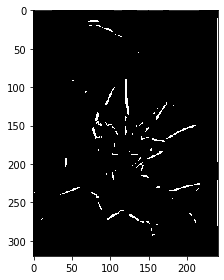

In [2]:
from skimage import io, data,filters
from skimage.color import *
import numpy as np
import matplotlib.pyplot as plt

def canny(img):
    # sobel filter
    def sobel_filter(img, K_size=3):  # K_size : the height of the kernal
        if len(img.shape) == 3:
            width, height, depth = img.shape
        else:
            width, height = img.shape

        # Zero padding
        pad = K_size // 2
        out = np.zeros((width + pad * 2, height + pad * 2), dtype=np.float)
        out[pad: pad + width, pad: pad + height] = img.copy().astype(np.float)
        tmp = out.copy()

        out_v = out.copy()
        out_h = out.copy()

        ## Sobel vertical
        Kv = [[1., 2., 1.], [0., 0., 0.], [-1., -2., -1.]]
        ## Sobel horizontal
        Kh = [[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]

        # filtering
        for iRow in range(width):
            for iCol in range(height):
                out_v[pad + iRow, pad + iCol] = np.sum(Kv * (tmp[iRow: iRow + K_size, iCol: iCol + K_size]))
                out_h[pad + iRow, pad + iCol] = np.sum(Kh * (tmp[iRow: iRow + K_size, iCol: iCol + K_size]))

        # resize the output
        out_v = out_v[pad: pad + width, pad: pad + height]
        fy = out_v.astype(np.uint8)
        out_h = out_h[pad: pad + width, pad: pad + height]
        fx = out_h.astype(np.uint8)

        return fy, fx


# get edge strength and edge angle
    def get_edge_angle(fx, fy):
        # get edge strength
        edge = np.sqrt(np.power(fx.astype(np.float32), 2) + np.power(fy.astype(np.float32), 2))

        # make sure the denominator is not 0
        fx = np.maximum(fx, 1e-10)

        # get edge angle
        angle = np.arctan(fy / fx)

        return edge, angle


# Quantify to 0°、45°、90°、135°
    def angle_quantization(angle):
        angle = angle / np.pi * 180
        angle[angle < -22.5] = 180 + angle[angle < -22.5]
        _angle = np.zeros_like(angle, dtype=np.uint8)
        _angle[np.where(angle <= 22.5)] = 0
        _angle[np.where((angle > 22.5) & (angle <= 67.5))] = 45
        _angle[np.where((angle > 67.5) & (angle <= 112.5))] = 90
        _angle[np.where((angle > 112.5) & (angle <= 157.5))] = 135

        return _angle


    def non_maximum_suppression(angle, edge):
        width, height = angle.shape
        _edge = edge.copy()

        for iRow in range(width):
            for iCol in range(height):
                if angle[iRow, iCol] == 0:
                    dx1, dy1, dx2, dy2 = -1, 0, 1, 0
                elif angle[iRow, iCol] == 45:
                    dx1, dy1, dx2, dy2 = -1, 1, 1, -1
                elif angle[iRow, iCol] == 90:
                    dx1, dy1, dx2, dy2 = 0, -1, 0, 1
                elif angle[iRow, iCol] == 135:
                    dx1, dy1, dx2, dy2 = -1, -1, 1, 1
                # boundary address
                if iCol == 0:
                    dx1 = max(dx1, 0)
                    dx2 = max(dx2, 0)
                if iCol == height - 1:
                    dx1 = min(dx1, 0)
                    dx2 = min(dx2, 0)
                if iRow == 0:
                    dy1 = max(dy1, 0)
                    dy2 = max(dy2, 0)
                if iRow == width - 1:
                    dy1 = min(dy1, 0)
                    dy2 = min(dy2, 0)
                # if not the maximum, set to 0
                if max(max(edge[iRow, iCol], edge[iRow + dy1, iCol + dx1]), edge[iRow + dy2, iCol + dx2]) != edge[
                    iRow, iCol]:
                    _edge[iRow, iCol] = 0

        return _edge


    def hysteresis(edge, HT, LT):
        width, height = edge.shape

        # Histeresis threshold
        edge[edge >= HT] = 255
        edge[edge <= LT] = 0

        _edge = np.zeros((width + 2, height + 2), dtype=np.float32)
        _edge[1: width + 1, 1: height + 1] = edge

        ## 8 - Nearest neighbor
        # If between HT and LT, and neighbour > HT, set to 255
        nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

        for y in range(1, width + 2):
            for x in range(1, height + 2):
                if _edge[y, x] < LT or _edge[y, x] > HT:
                    continue
                if np.max(_edge[y - 1:y + 2, x - 1:x + 2] * nn) >= HT:
                    _edge[y, x] = 255
                else:
                    _edge[y, x] = 0

        edge = _edge[1:width + 1, 1:height + 1]

        return edge

    img3 = filters.gaussian(img, sigma=1.3)  # add the gaussian filter
    fy, fx = sobel_filter(img3, K_size=3)
    edge, angle = get_edge_angle(fx, fy)
    edge2 = non_maximum_suppression(angle, edge)
    out = hysteresis(edge2, 80, 10)
    out = out.astype(np.uint8)

    return out

if __name__ == '__main__':
    # Read image
    img = io.imread("yugi.jpg")
    #width, height, depth = img.shape
    img2 = rgb2gray(img)
    out = canny(img2)

    io.imshow(out)
    io.show()


In [9]:
np.max(out)

255

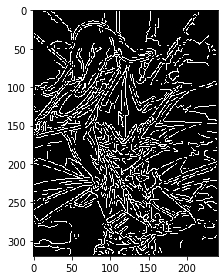

In [4]:
from skimage import feature
ou = io.imread("yugi.jpg")
ou = rgb2gray(ou)
ou=feature.canny(ou)
io.imshow(ou,cmap="gray")